### Dependencies

In [150]:
# from tensorflow.keras.layers import LSTM, Dense, Bidirectional
import os
import sys
import csv
import glob
import joblib
import numpy as np
import pandas as pd
import tensorflow as tf
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras import layers # LSTM, Dense, Bidirectional are under this
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.pyplot import MultipleLocator
from IPython.display import IFrame
from plotly.offline import plot
from time import time

print(sys.executable)
print(tf.__version__)
!python --version

c:\Users\happy\.pyenv\pyenv-win\versions\3.8.10\python.exe
2.13.0
Python 3.8.10


### Data preprocessing

In [151]:
# def deg_to_trig(theta):
#     theta = np.radians(float(theta))
#     tsin = round(np.sin(theta), 6)
#     tcos = round(np.cos(theta), 6)
#     return tsin, tcos

def deg_to_trig(theta_series):
    theta_series = theta_series.apply(lambda theta: np.radians(float(theta)))
    tsin = theta_series.apply(lambda theta: round(np.sin(theta), 6))
    tcos = theta_series.apply(lambda theta: round(np.cos(theta), 6))
    return tsin, tcos

def trig_to_deg(tsin, tcos):
    return np.degrees(np.arctan2(tsin, tcos))

In [152]:
def preprocess_data(csv_file):
    # Assuming the CSV file has columns: ind, x, y, t, x', y', t'
    df = pd.read_csv(csv_file, header=None, usecols=[4, 5, 6, 7, 8, 9, 10])
    df.columns = ['ind', 'x', 'y', 't', 'x_', 'y_', 't_']

    one_hot_encoded = pd.get_dummies(df['ind'], prefix='ind')
    df = pd.concat([df, one_hot_encoded], axis=1)
    df['ind_2'] = df['ind_2'].astype(int)
    df['ind_4'] = df['ind_4'].astype(int)
    
    # Drop the original 'ind' column if you don't need it anymore
    df.drop('ind', axis=1, inplace=True)
    
    # Replace t and t_ with tsin tcos and tsin_ tcos_
    # df['tsin'], df['tcos'] = deg_to_trig(df['t'])
    # df['tsin_'], df['tcos_'] = deg_to_trig(df['t_'])

    tsin, tcos = deg_to_trig(df['t'])
    tsin_, tcos_ = deg_to_trig(df['t_'])
    
    # Add tsin, tcos, tsin_, tcos_ to DataFrame
    df['tsin'] = tsin
    df['tcos'] = tcos
    df['tsin_'] = tsin_
    df['tcos_'] = tcos_

    df.drop(['t', 't_'], axis=1, inplace=True)
    
    df = df.astype(float)
    # print(df.columns[df.columns.str.startswith('ind_')])

    # Splitting input and output data
    X = df[['ind_2', 'ind_4', 'x', 'y', 'tsin', 'tcos']].values
    y = df[['x_', 'y_', 'tsin_', 'tcos_']].values
    
    # Normalize the data (optional but recommended)
    # X_normalized = (X - X.mean()) / X.std()
    # y_normalized = (y - y.mean()) / y.std()
    
    return X, y

In [153]:
logs_data = []
for filename in glob.glob(f"dataset\\*.csv"):
    print(filename)
    X, y = preprocess_data(filename)
    # print(X)
    logs_data.append((X, y))

print("===== Data successfully loaded and preprocessed. =====")
# print(logs_data)
print(np.array(logs_data).shape) # (n, 2) : n files, each of which has a tuple (X, y)
print(np.array(logs_data)[0][1].shape) # (2, xxxx, 5) : df X and y, both of which has many rows and 5 columns  
# print(np.array(logs_data[1]).shape)
# print(logs_data[0])

dataset\COM5_20230510_191526.txt.csv
dataset\COM5_20230512_175106.txt.csv
dataset\COM5_20230512_175752.txt.csv
dataset\COM6_20230512_175102.txt.csv
dataset\COM6_20230512_175748.txt.csv
dataset\COM7_20230615_115259.txt.csv
===== Data successfully loaded and preprocessed. =====
(6, 2)
(5091, 4)


C:\Users\happy\AppData\Local\Temp\ipykernel_6052\1214773020.py:10: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

C:\Users\happy\AppData\Local\Temp\ipykernel_6052\1214773020.py:11: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [154]:
# Concatenate all logs data
X_concat = np.concatenate([data[0] for data in logs_data])
y_concat = np.concatenate([data[1] for data in logs_data])

test_size = 0.25

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_concat, y_concat, test_size=test_size, random_state=41)
X_test_raw = np.copy(X_test)

print(f'X_train.shape: {X_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'y_test.shape: {y_test.shape}')

normalizer = preprocessing.StandardScaler()
normalizer.fit(X_train[:, 2:4]) # Using only training data to fit is a common practice
X_train[:, 2:4] = normalizer.transform(X_train[:, 2:4])
X_test[:, 2:4] = normalizer.transform(X_test[:, 2:4])

# Reshape data for LSTM input (assuming a sequence length of 1) 
# 1 is timestep
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Not sure if needed
# y_train = y_train.reshape(y_train.shape[0], 1, y_train.shape[1])
# y_test = y_test.reshape(y_test.shape[0], 1, y_test.shape[1])

X_train.shape: (9325, 6)
X_test.shape: (3109, 6)
y_train.shape: (9325, 4)
y_test.shape: (3109, 4)


In [155]:
X_concat.shape

(12434, 6)

### Model Architecture

In [156]:
# Creating directory for saving results
run_number = 1
while os.path.exists(f"run{run_number}"):
    run_number += 1
os.makedirs(f"run{run_number}")

In [157]:
# Build the Bi-LSTM model
model = Sequential()
# model.add(layers.Bidirectional(layers.LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2]))))
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(y_train.shape[1]))  # Output layer

# Input layer
# input_shape = (timesteps, features)
model.add(layers.Dense(32, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'))
model.add(layers.BatchNormalization())
# model.add(layers.Bidirectional(layers.LSTM(units=64, return_sequences=True)))
# model.add(layers.BatchNormalization())

# Hidden layers
# model.add(layers.Bidirectional(layers.LSTM(units=64, return_sequences=True)))
# model.add(layers.BatchNormalization())
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.BatchNormalization())

model.add(layers.Bidirectional(layers.LSTM(units=64)))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.BatchNormalization())

# Output layer
model.add(layers.Dense(y_train.shape[1]))

model.build(input_shape=(None, X_train.shape[1], X_train.shape[2]))

In [158]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 1, 32)             224       
                                                                 
 batch_normalization_19 (Ba  (None, 1, 32)             128       
 tchNormalization)                                               
                                                                 
 bidirectional_8 (Bidirecti  (None, 128)               49664     
 onal)                                                           
                                                                 
 batch_normalization_20 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dense_18 (Dense)            (None, 64)                8256      
                                                      

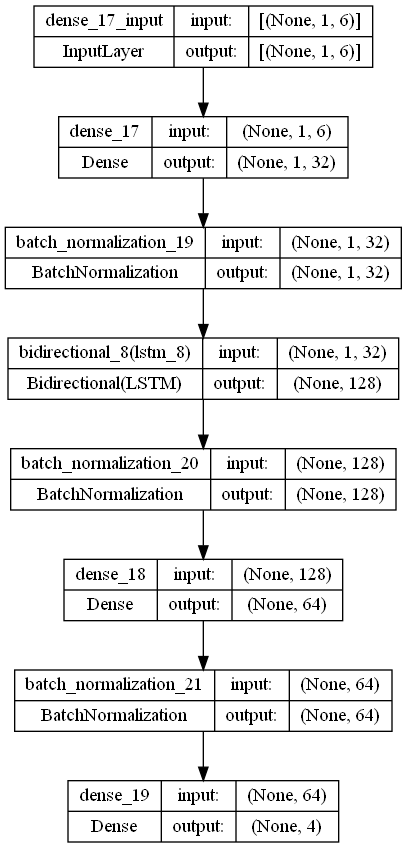

In [159]:
tf.keras.utils.plot_model(
    model, to_file=f"run{run_number}/model.png", show_shapes=True, show_layer_names=True)

In [160]:
ES_patience = 15
ReduceLRpatience = 10
ReduceLRfactor = 0.5
min_lr = 1e-5

# Configurable parameters
learning_rate = 0.001
batch_size = 64
epochs = 250

checkpoint = ModelCheckpoint(
    f"run{run_number}/best_model.h5", monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(
    monitor='val_loss', patience=ES_patience, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=ReduceLRfactor, patience=ReduceLRpatience, min_lr=min_lr, verbose=1)

# Compile the model
# model.compile(optimizer='adam', loss='mse')
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

### Training

In [161]:
try:
    start_time = time()
    history = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[checkpoint, early_stopping, reduce_lr])
except KeyboardInterrupt:
    print("\nTraining manually stopped.")

model.save_weights(f'run{run_number}/model_weights_interrupted.h5')
end_time = time()

training_duration = end_time - start_time
print(f"Training Duration: {training_duration:.2f} seconds")

# Add an 'epoch' column to the history DataFrame
history_df = pd.DataFrame(history.history)
# Add 'epoch' column with values starting from 1
history_df['epoch'] = history_df.index + 1

# Reorder the columns to have 'epoch' as the first column
history_df = history_df[['epoch'] +
                        [col for col in history_df.columns if col != 'epoch']]
# Save training history with 'epoch' as the first column
history_df.to_csv(f"run{run_number}/training_history.csv", index=False)

# Save the scaler and encoder
joblib.dump(normalizer, f"run{run_number}/normalizer.pkl")
# joblib.dump(encoder, f"run{run_number}/encoder.pkl")

# Compute and save the normalized confusion matrix
# x_orig = model.predict(X_test)

# Access the last epoch details
last_epoch_data = int(history_df.iloc[-1][0])

# Save training parameters and duration
training_parameters = {
    "Model Name": "Res-Bi-LSTM",
    "Learning Rate": learning_rate,
    "Batch Size": batch_size,
    "Test Size": test_size,
    "Training Duration (seconds)": training_duration,
    "Epochs": last_epoch_data,
    "Dynamic Learning Rate": "monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6",
    "Early Stopping Patience": ES_patience,
    "Reduce LR patience": ReduceLRpatience,
    "Reduce LR factor": ReduceLRfactor,
    "Reduce LR Minimum": min_lr,
    "More": "Adjust layer units"
}

# Write parameters to a text file
with open(f"run{run_number}/training_parameters.txt", 'w') as file:
    for key, value in training_parameters.items():
        file.write(f"{key}: {value}\n")

Epoch 1/250


143/146 [============================>.] - ETA: 0s - loss: 798.7846
Epoch 1: val_loss improved from inf to 906.68512, saving model to run13\best_model.h5
146/146 [==============================] - 8s 14ms/step - loss: 796.1171 - val_loss: 906.6851 - lr: 0.0010
Epoch 2/250
 13/146 [=>............................] - ETA: 1s - loss: 657.5861

C:\Users\happy\AppData\Roaming\Python\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



142/146 [============================>.] - ETA: 0s - loss: 557.9802
Epoch 2: val_loss improved from 906.68512 to 573.93280, saving model to run13\best_model.h5
146/146 [==============================] - 1s 9ms/step - loss: 555.5021 - val_loss: 573.9328 - lr: 0.0010
Epoch 3/250
143/146 [============================>.] - ETA: 0s - loss: 338.7593
Epoch 3: val_loss improved from 573.93280 to 256.43289, saving model to run13\best_model.h5
146/146 [==============================] - 1s 9ms/step - loss: 336.4379 - val_loss: 256.4329 - lr: 0.0010
Epoch 4/250
141/146 [===========================>..] - ETA: 0s - loss: 145.6690
Epoch 4: val_loss improved from 256.43289 to 68.92164, saving model to run13\best_model.h5
146/146 [==============================] - 1s 9ms/step - loss: 143.2418 - val_loss: 68.9216 - lr: 0.0010
Epoch 5/250
141/146 [===========================>..] - ETA: 0s - loss: 40.8182
Epoch 5: val_loss improved from 68.92164 to 9.98827, saving model to run13\best_model.h5
146/146 [===

### Training Results

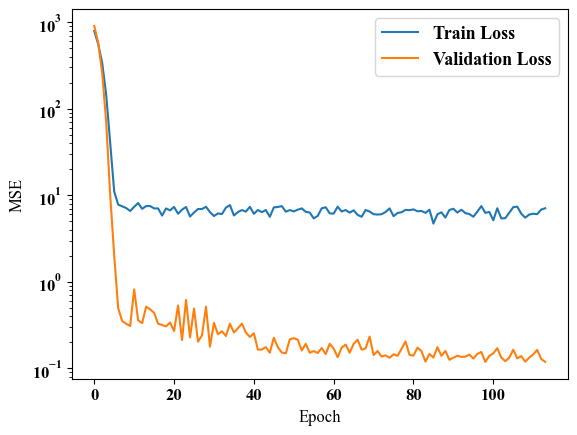

In [162]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(fontsize=13)
plt.savefig(f'run{run_number}/training.png',
            facecolor='white', edgecolor='black')

In [163]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

98/98 [==============================] - 0s 3ms/step - loss: 0.1187
Test Loss: 0.1186949610710144


     epoch        loss    val_loss        lr
0        1  796.117126  906.685120  0.001000
1        2  555.502136  573.932800  0.001000
2        3  336.437897  256.432892  0.001000
3        4  143.241837   68.921638  0.001000
4        5   40.088997    9.988272  0.001000
..     ...         ...         ...       ...
109    110    5.986862    0.132999  0.000063
110    111    6.125915    0.145017  0.000063
111    112    6.055762    0.163361  0.000063
112    113    6.839415    0.128525  0.000063
113    114    7.082250    0.119071  0.000063

[114 rows x 4 columns]

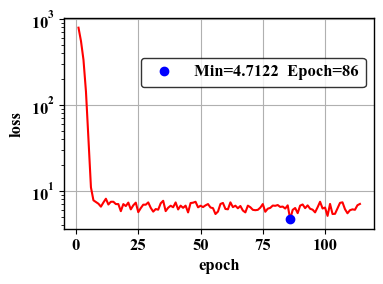

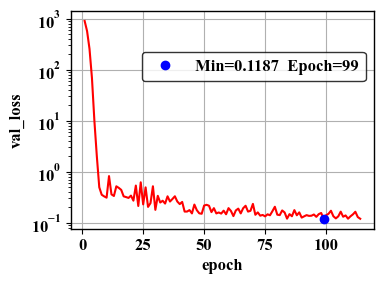

In [164]:
df = pd.read_csv(f"run{run_number}\\training_history.csv")

print(df)

# Remove leading/trailing whitespaces from column names
df.columns = df.columns.str.strip()

# Setting the font to Times New Roman and bold for all text
# rcParams = runtime configuration parameters
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.size'] = 12

metrics = ['loss', 'val_loss']

for metric in metrics:
    # Adjusting the figure size to match the aspect ratio of the image
    # You may need to tweak these numbers to match the exact ratio
    plt.figure(figsize=(4, 3))

    # Plot with red color without adding a label to avoid adding it to the legend
    plt.plot(df['epoch'], df[metric], 'r-') # r- = Red solid line

    # Find min or max value and corresponding epoch, then update legend text accordingly
    legend_label = None  # Initialize the legend label to None
    if 'loss' in metric:
        min_loss_epoch = df['epoch'][df[metric].idxmin()]
        min_loss = df[metric].min()
        legend_label = f'Min={min_loss:.4f}  Epoch={min_loss_epoch}'
        plt.plot(min_loss_epoch, min_loss, 'bo', label=legend_label)
    else:
        max_value_epoch = df['epoch'][df[metric].idxmax()]
        max_value = df[metric].max()
        legend_label = f'Max={max_value:.4f}  Epoch={max_value_epoch}'
        plt.plot(max_value_epoch, max_value, 'bo', label=legend_label)

    plt.yscale("log")
    # Set axis labels with bold font
    plt.xlabel('epoch', fontweight='bold')
    plt.ylabel(metric, fontweight='bold')

    # Make legend compact and with a white background and black border
    if legend_label:  # Only add the legend if there is a label for the blue points
        plt.legend(loc='upper right', bbox_to_anchor=(1, 0.85),
                   frameon=True, facecolor='white', edgecolor='black')

    # Set axes background to white and remove gridlines
    ax = plt.gca()
    ax.set_facecolor('white')
    plt.grid(True)

    # Adding an outline to the plot
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)

    # Replace '/' in metric name with '_', keep 'train' and 'val' in the file name
    # filename = metric.replace('/', '_') # Not needed?
    plt.tight_layout()  # Adjust the layout of the figure to avoid partially cut images
    plt.savefig(f'run{run_number}\\{metric}.png', facecolor='white',
                edgecolor='black')  # Ensuring white background and black edge

    # plt.close()

### Visualize results

In [165]:
def plot_results(y_pred, y_test, run_number, raw=False):
    # Not needed after conversion in the caller
    # if raw == True:
    #     y_pred = y_pred[:, :, 2:]

    # Reverse normalization ???
    y_pred_original = y_pred.reshape(-1, 4)
    y_actual_original = y_test.reshape(-1, 4)

    # Convert (tsin, tcos) back to theta
    pred_theta = trig_to_deg(y_pred_original[:, 2], y_pred_original[:, 3])
    actual_theta = trig_to_deg(y_actual_original[:, 2], y_actual_original[:, 3])
    
    # pred_ind = y_pred_original[:, 0]
    # actual_ind = y_actual_original[:, 0]

    # Creating combined hover text
    combined_hover_text = []
    for pred, act, pred_theta, act_theta in zip(y_pred_original, y_actual_original, pred_theta, actual_theta):
        hover_text = f"Predicted: X={pred[0]:.2f}, Y={pred[1]:.2f}, θ={int(pred_theta)}°<br>Actual: X={act[0]:.2f}, Y={act[1]:.2f}, θ={int(act_theta)}°"
        combined_hover_text.append(hover_text)

    # Creating trace for predicted values
    trace_pred = go.Scatter(
        x=y_pred_original[:, 0],
        y=y_pred_original[:, 1],
        mode='markers',
        marker=dict(color='blue'),
        text=combined_hover_text,
        name='Predicted'
    )

    # Creating trace for actual values
    # Skip hover for actual points, as information is already in predicted points
    trace_actual = go.Scatter(
        x=y_actual_original[:, 0],
        y=y_actual_original[:, 1],
        mode='markers',
        marker=dict(color='orange'),
        text=combined_hover_text,
        name='Actual',
        hoverinfo='skip'
    )

    # Layout for the plot
    layout = dict(title='Positions and Angles',
                  xaxis=dict(title='X'),
                  yaxis=dict(title='Y'),
                  hovermode='closest'
                  )

    # Combining traces into data
    data = [trace_pred, trace_actual]

    # Create figure and plot
    fig = dict(data=data, layout=layout)
    if raw == True:
        plot_file = f"run{run_number}\\interactive_plot_raw.html"
        plot(fig, filename=plot_file, auto_open=False)

        # Display the plot in JupyterLab
        # display(IFrame(plot_file, width='100%', height='800px'))

    else:
        plot_file = f"run{run_number}\\interactive_plot.html"
        plot(fig, filename=plot_file, auto_open=False)
        
        # Display the plot in JupyterLab
        # display(IFrame(plot_file, width='100%', height='800px'))

    # img = mpimg.imread(plot_file)
    # plt.imshow(img)
    # plt.axis('off')  # Hide axis labels and ticks
    # plt.show()
    
def evaluate_model(model, X_test, X_test_raw, y_test, run_number):
    # Predict using the model
    y_pred = model.predict(X_test)
    X_test_raw = X_test_raw[:, 2:].reshape(-1, 4) # reshape() to ensure the shape

    # Calculate mean squared error or any other performance metrics
    mse = np.mean((y_test - y_pred)**2)
    mse_raw = np.mean((y_test - X_test_raw)**2)

    # Call the plotting functions with corrected data
    plot_results(y_pred, y_test, run_number)
    plot_results(X_test_raw, y_test, run_number, raw=True)

    # Save evaluation results
    with open(f"run{run_number}\\evaluation_results.txt", 'w') as file:
        file.write(f"Mean Squared Error (raw): {mse_raw}\n")
        file.write(f"Mean Squared Error: {mse}\n")

    return mse, mse_raw


In [166]:
X_test_raw[:, 2:].shape
# y_test.shape

(3109, 4)

In [167]:
model = load_model(f'run{run_number}/best_model.h5')
# model = load_model(f'best_model.h5')

# Evaluate the model
mse, mse_raw = evaluate_model(model, X_test, X_test_raw, y_test, run_number)
print(f"Mean Squared Error(raw): {mse_raw}")
print(f"Mean Squared Error: {mse}")

98/98 [==============================] - 2s 3ms/step
Mean Squared Error(raw): 0.295338016714931
Mean Squared Error: 0.11869496447916802


### Model Evaluation

In [168]:
def preprocess_data_eval(csv_file):
    df = pd.read_csv(csv_file, header=None, usecols=[4, 5, 6, 7])
    df.columns = ['ind', 'x', 'y', 't']

    one_hot_encoded = pd.get_dummies(df['ind'], prefix='ind')
    df = pd.concat([df, one_hot_encoded], axis=1)
    df['ind_2'] = df['ind_2'].astype(int)
    df['ind_4'] = df['ind_4'].astype(int)
    
    # Drop the original 'ind' column if you don't need it anymore
    df.drop('ind', axis=1, inplace=True)
    
    tsin, tcos = deg_to_trig(df['t'])
    
    # Add tsin, tcos, tsin_, tcos_ to DataFrame
    df['tsin'] = tsin
    df['tcos'] = tcos

    df.drop(['t'], axis=1, inplace=True)
    
    df = df.astype(float)

    # Splitting input and output data
    X = df[['ind_2', 'ind_4', 'x', 'y', 'tsin', 'tcos']].values
        
    return X

In [169]:
data_dir = 'Dataset\\Testing'
files = glob.glob(f"{data_dir}\\*.csv")
tr_files = glob.glob(f"Dataset\\*.csv")
logs_data_eval = []
for i, filename in enumerate(files):
    print(i, " ", filename)

for file in files:
    X = preprocess_data_eval(file)
    y = np.zeros(X.shape)
    logs_data_eval.append((X, y))

for file in tr_files:
    X = preprocess_data_eval(file)
    y = np.zeros(X.shape)
    logs_data_eval.append((X, y))

tr_files = [os.path.join(os.path.dirname(file), 'tr_' + os.path.basename(file)) for file in tr_files]
files = files + tr_files

# file = glob.glob(f"{data_dir}\\*.csv")[1]
# X = preprocess_data_X(file)
# logs_data_eval.append((X))

print("===== Data successfully loaded and preprocessed. =====")
# print(logs_data_eval)
print(np.array(logs_data_eval).shape)
print(np.array(logs_data_eval[0]).shape)
# print(np.array(logs_data_eval[1]).shape)
# print(logs_data_eval[0])

0   Dataset\Testing\COM4_20230510_193014.txt.csv
1   Dataset\Testing\COM5_20230510_193030.txt.csv
2   Dataset\Testing\COM5_20230512_180404.txt.csv
3   Dataset\Testing\COM6_20230512_180353.txt.csv
4   Dataset\Testing\COM7_20230615_115259.txt.csv
===== Data successfully loaded and preprocessed. =====
(11, 2)
(2, 4861, 6)


C:\Users\happy\AppData\Local\Temp\ipykernel_6052\94824207.py:27: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [170]:
# a = np.array([[2, 4, 6],
#               [2, 3, 8],
#               [1, 2, 6],
#               [4, 6, 7]])

# print(a[:, 2])

X_list = []
for log in logs_data_eval:
    # print(np.array(log).shape)
    # print(np.array(log)[0].shape)
    # print(np.array(log[0]).shape)
    X_normalized = np.array(log[0])
    X_raw = np.copy(X_normalized)
    X_normalized[:, 2:4] = normalizer.transform(X_normalized[:, 2:4])
    X_list.append((X_normalized, X_raw))  # Append the original X array without concatenation
# print(np.array(X_concat_list)[0].shape)

X_test = []
X_test_raw = []
# print(np.array(X_list[0][0]).shape)
for x in X_list:
    # print(np.array(x[0]).shape)
    X_raw = np.copy(x[1])
    x = x[0]
    X_tmp = x.reshape(x.shape[0], 1, x.shape[1])
    X_test.append(X_tmp)
    X_test_raw.append(X_raw)

X_test = np.array(X_test)
# print(X_test.shape)
print(X_test[0].shape)
# print(X_test[0].shape[0]*6) # debugging

(4861, 1, 6)


C:\Users\happy\AppData\Local\Temp\ipykernel_6052\531922799.py:30: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [171]:
# Creating directory for saving results
# run_number = 6
test_number = 1
while os.path.exists(f"test{test_number}"):
    test_number += 1
os.makedirs(f"test{test_number}")

In [172]:
def plot_results_eval(X_test, y_test, run_number, filename, raw=False):
    X_test_original = X_test.reshape(-1, 4)
    y_pred_original = y_test.reshape(-1, 4)

    # Convert (tsin, tcos) back to theta
    orig_theta = trig_to_deg(X_test_original[:, 2], X_test_original[:, 3])
    pred_theta = trig_to_deg(y_pred_original[:, 2], y_pred_original[:, 3])

    # Creating combined hover text
    combined_hover_text = []
    for orig, pred, orig_theta, pred_theta in zip(X_test_original, y_pred_original, orig_theta, pred_theta):
        hover_text = f"Predicted: X={orig[0]:.2f}, Y={orig[1]:.2f}, θ={int(orig_theta)}°<br>Actual: X={pred[0]:.2f}, Y={pred[1]:.2f}, θ={int(pred_theta)}°"
        combined_hover_text.append(hover_text)

    # Creating trace for predicted values
    trace_orig = go.Scatter(
        x=X_test_original[:, 0],
        y=X_test_original[:, 1],
        mode='markers',
        marker=dict(color='blue'),
        text=combined_hover_text,
        name='Original'
    )

    # Creating trace for actual values
    # Skip hover for actual points, as information is already in predicted points
    trace_pred = go.Scatter(
        x=y_pred_original[:, 0],
        y=y_pred_original[:, 1],
        mode='markers',
        marker=dict(color='orange'),
        text=combined_hover_text,
        name='Improved',
        # hoverinfo='skip'
    )

    # Layout for the plot
    layout = dict(title='Positions and Angles',
                  xaxis=dict(title='X'),
                  yaxis=dict(title='Y'),
                  hovermode='closest'
                  )

    # Combining traces into data
    data = [trace_orig, trace_pred]

    # Create figure and plot
    fig = dict(data=data, layout=layout)
    if raw == True:
        plot_file = f"test{test_number}\\{filename}_raw.html"
        plot(fig, filename=plot_file, auto_open=False)
    else:
        plot_file = f"test{test_number}\\{filename}.html"
        plot(fig, filename=plot_file, auto_open=False)
        
def evaluate_model_noY(model, X_test, X_test_raw, test_number, filename):
    y_test = model.predict(X_test)
    X_test_raw = X_test_raw.reshape(-1, 6)
    X_test_raw = X_test_raw[:, 2:]
    plot_results_eval(X_test_raw, y_test, test_number, filename, raw=True)

In [173]:
model = load_model(f'run{run_number}/best_model.h5')
# model = load_model(f'best_model.h5')

# Evaluate the model
for i, (t, r) in enumerate(zip(X_test, X_test_raw)):
    evaluate_model_noY(model, t, r, test_number, os.path.basename(files[i]))

# Save training parameters and duration
testing_details = {
    "model(run_number)": run_number,
    "Log used: {len(files)}\n": '\n'.join(files)    
}

# Write parameters to a text file
with open(f"test{test_number}/testing_details.txt", 'w') as file:
    for key, value in testing_details.items():
        file.write(f"{key}: {value}\n")

39/39 [==============================] - 0s 2ms/step
